<a href="https://colab.research.google.com/github/sholtodouglas/learning_from_play/blob/master/notebooks/train_lfp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install wandb -q
!pip install pathy -q

     |████████████████████████████████| 2.0MB 6.9MB/s 
     |████████████████████████████████| 163kB 24.7MB/s 
     |████████████████████████████████| 133kB 13.0MB/s 
     |████████████████████████████████| 102kB 7.4MB/s 
     |████████████████████████████████| 71kB 9.0MB/s 
     |████████████████████████████████| 122kB 9.3MB/s 


In [2]:
import argparse

parser = argparse.ArgumentParser(description='LFP training arguments')
parser.add_argument('run_name')
parser.add_argument('--train_datasets', nargs='+', help='Training dataset names')
parser.add_argument('--test_datasets', nargs='+', help='Testing dataset names')
parser.add_argument('-c', '--colab', default=False, action='store_true', help='Enable if using colab environment')
parser.add_argument('-s', '--data_source', default='DRIVE', help='Source of training data')
parser.add_argument('-tfr', '--from_tfrecords', default=False, action='store_true', help='Enable if using tfrecords format')
parser.add_argument('-d', '--device', default='TPU', help='Hardware device to train on')
parser.add_argument('-b', '--batch_size', default=512, type=int)
parser.add_argument('-la', '--actor_layer_size', default=2048, type=int, help='Layer size of actor, increases size of neural net')
parser.add_argument('-le', '--encoder_layer_size', default=512, type=int, help='Layer size of encoder, increases size of neural net')
parser.add_argument('-lp', '--planner_layer_size', default=512, type=int, help='Layer size of planner, increases size of neural net')
parser.add_argument('-z', '--latent_dim', default=256, type=int, help='Size of the VAE latent space')
parser.add_argument('-g', '--gcbc', default=False, action='store_true', help='Enables GCBC, a simpler model with no encoder/planner')
parser.add_argument('-n', '--num_distribs', default=None, type=int, help='Number of distributions to use in logistic mixture model')
parser.add_argument('-q', '--qbits', default=None, type=int, help='Number of quantisation bits to discrete distributions into. Total quantisations = 2**qbits')
parser.add_argument('-lr', '--learning_rate', type=float, default=3e-4)
parser.add_argument('-t', '--train_steps', type=int, default=100000)
parser.add_argument('-r', '--resume', default=False, action='store_true')


# args = parser.parse_args()

### Sample local config
args = parser.parse_args('''
dummy_run 
--train_dataset UR5
--test_dataset UR5
-tfr
'''.split())

## Sample colab config
args = parser.parse_args('''
refactor_test
--train_dataset UR5 UR5_slow_gripper UR5_high_transition
--test_dataset UR5_slow_gripper_test
-c
-tfr
-s GCS
-d TPU
-b 512
-la 2048
-le 512
-lp 2048
-z 256
-lr 3e-4
'''.split())

## Sample colab config
args = parser.parse_args('''
reclass2_from_working
--train_dataset UR5 UR5_slow_gripper UR5_high_transition
--test_dataset UR5_slow_gripper_test
-c
-s DRIVE
-d TPU
-b 512
-la 2048
-le 512
-lp 512
-z 256
-lr 3e-4
'''.split())

print(args)

Namespace(actor_layer_size=2048, batch_size=512, colab=True, data_source='DRIVE', device='TPU', encoder_layer_size=512, from_tfrecords=False, gcbc=False, latent_dim=256, learning_rate=0.0003, num_distribs=None, planner_layer_size=512, qbits=None, resume=False, run_name='reclass2_from_working', test_datasets=['UR5_slow_gripper_test'], train_datasets=['UR5', 'UR5_slow_gripper', 'UR5_high_transition'], train_steps=100000)


## Init

In [3]:
#@title Workpace Setup (Local vs Colab)
from pathlib import Path
import os

# COLAB = False #@param {type:"boolean"}
AUTH_GCS = False #@param {type:"boolean"}
# DEVICE = "CPU" #@param ["TPU", "GPU", "CPU"]
DATA_SOURCE = "Google Drive" #@param ["Google Drive", "GCS"]
# TRAIN_DATASETS = ["UR5"]#,"UR5_slow_gripper","UR5_high_transition"]
# TEST_DATASET = "UR5_slow_gripper_test" #@param ["UR5_slow_gripper_test"]
GCS_USER = "sholto" #@param ["sholto", "tristan"]

if args.colab:
    from google.colab import drive, auth
    print('Using colab setup')
    !git clone 'https://github.com/sholtodouglas/learning_from_play'
    WORKING_PATH = Path('/content/learning_from_play')
    drive.mount('/content/drive')
    os.chdir(WORKING_PATH)
    STORAGE_PATH = Path('/content/drive/My Drive/Robotic Learning')
    print(f'Storage path: {STORAGE_PATH}')
else:
    print('Using local setup')
    WORKING_PATH = Path().absolute().parent
    print(f'Working path: {WORKING_PATH}')
    os.chdir(WORKING_PATH)
    STORAGE_PATH = WORKING_PATH
    print(f'Storage path: {STORAGE_PATH}')

TRAIN_DATA_PATHS = [STORAGE_PATH/'data'/x for x in args.train_datasets]
TEST_DATA_PATHS = [STORAGE_PATH/'data'/x for x in args.test_datasets]

Using colab setup
Cloning into 'learning_from_play'...
remote: Enumerating objects: 55, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 1749 (delta 32), reused 9 (delta 4), pack-reused 1694
Receiving objects: 100% (1749/1749), 57.59 MiB | 40.92 MiB/s, done.
Resolving deltas: 100% (989/989), done.
Mounted at /content/drive
Storage path: /content/drive/My Drive/Robotic Learning


In [4]:
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

if args.device == "TPU":
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
        print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
    except ValueError:
        raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)

    NUM_DEVICES = strategy.num_replicas_in_sync
    print("REPLICAS: ", NUM_DEVICES)
else:
    physical_devices = tf.config.list_physical_devices()
    if args.device == 'GPU':
        tf.config.experimental.set_memory_growth(physical_devices[3], enable=True)
    NUM_DEVICES = 1
    print(physical_devices)

Tensorflow version 2.4.1
Running on TPU  ['10.84.19.34:8470']
INFO:tensorflow:Initializing the TPU system: grpc://10.84.19.34:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.84.19.34:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


REPLICAS:  8


In [5]:
import glob
import numpy as np
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
import random
import pickle
import os
from collections import Counter
import random
import datetime

import lfp
from natsort import natsorted

In [ ]:
# Use this to edit modules without needing to restart the kernel
# !git pull
# import importlib
# importlib.reload(lfp.data)
# importlib.reload(lfp.model)
# importlib.reload(lfp.train)
# importlib.reload(lfp.metric)

## Data

In [8]:
GLOBAL_BATCH_SIZE = args.batch_size * NUM_DEVICES
dl = lfp.data.PlayDataloader(batch_size=GLOBAL_BATCH_SIZE)

In [9]:
# Train data
train_data = dl.extract(TRAIN_DATA_PATHS)
train_dataset = dl.load(train_data)

UR5_high_transition: 100%|██████████| 32/32 [00:11<00:00,  2.72it/s]


{   'acts': TensorSpec(shape=(4096, 50, 7), dtype=tf.float32, name=None),
    'dataset_path': TensorSpec(shape=(4096, None, 1), dtype=tf.int32, name=None),
    'goals': TensorSpec(shape=(4096, 50, 11), dtype=tf.float32, name=None),
    'masks': TensorSpec(shape=(4096, 50), dtype=tf.float32, name=None),
    'obs': TensorSpec(shape=(4096, 50, 18), dtype=tf.float32, name=None),
    'seq_lens': TensorSpec(shape=(4096,), dtype=tf.float32, name=None),
    'tstep_idxs': TensorSpec(shape=(4096, None, 1), dtype=tf.int32, name=None)}


In [10]:
# Validation data
valid_data = dl.extract(TEST_DATA_PATHS)
valid_dataset = dl.load(valid_data)

UR5_slow_gripper_test: 100%|██████████| 2/2 [00:00<00:00,  2.35it/s]

{   'acts': TensorSpec(shape=(4096, 50, 7), dtype=tf.float32, name=None),
    'dataset_path': TensorSpec(shape=(4096, None, 1), dtype=tf.int32, name=None),
    'goals': TensorSpec(shape=(4096, 50, 11), dtype=tf.float32, name=None),
    'masks': TensorSpec(shape=(4096, 50), dtype=tf.float32, name=None),
    'obs': TensorSpec(shape=(4096, 50, 18), dtype=tf.float32, name=None),
    'seq_lens': TensorSpec(shape=(4096,), dtype=tf.float32, name=None),
    'tstep_idxs': TensorSpec(shape=(4096, None, 1), dtype=tf.int32, name=None)}


# Training Loop

In [11]:
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import Progbar
import tensorflow_addons as tfa
import tensorflow_probability as tfp
tfd = tfp.distributions

import time
import io
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [38]:
from lfp.train import LFPTrainer

def train_setup():
    model_params = {'obs_dim':dl.obs_dim,
                'goal_dim':dl.goal_dim,
                'act_dim':dl.act_dim,
                'layer_size':args.actor_layer_size, 
                'latent_dim':args.latent_dim}
    
    actor = lfp.model.create_actor(**model_params, gcbc=args.gcbc, num_distribs=args.num_distribs)

    if args.gcbc:
        encoder = None
        planner = None
    else:
        model_params['layer_size'] = args.encoder_layer_size
        encoder = lfp.model.create_encoder(**model_params)
        model_params['layer_size'] = args.planner_layer_size
        planner = lfp.model.create_planner(**model_params)

    optimizer = tf.optimizers.Adam(learning_rate=args.learning_rate)
    trainable_variables = actor.trainable_variables + encoder.trainable_variables + planner.trainable_variables
    return actor, encoder, planner, optimizer, trainable_variables

if args.device=='CPU' or args.device=='GPU':
    actor, encoder, planner, optimizer, trainable_variables = train_setup()
else:
    with strategy.scope():
        actor, encoder, planner, optimizer, trainable_variables = train_setup()
        trainer= LFPTrainer(actor, encoder, planner, optimizer, strategy, args, dl)
        
train_dist_dataset = iter(strategy.experimental_distribute_dataset(train_dataset))
valid_dist_dataset = iter(strategy.experimental_distribute_dataset(valid_dataset))
plotting_dataset = iter(valid_dataset) #for the cluster fig, easier with a non distributed dataset

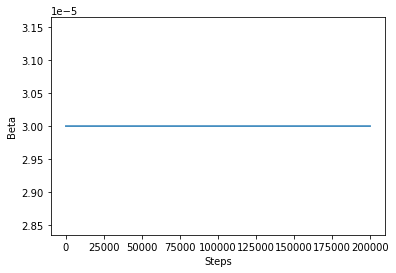

In [24]:
from lfp.train import BetaScheduler

TRAIN_STEPS = 200000
# 0.00001 so far works best for MAE - try lower - 0.00003 with a BETA accel of 10 so far works best, perfect encoder, nicely mapped planner
# recall 0.01 worked okay for probabilistic - proba still too unstable!
beta_sched = BetaScheduler('linear', 
                           beta=0.00003, 
                           beta_max=0.00003, 
                           max_steps=TRAIN_STEPS, 
                           cycles=90, 
                           duty_cycle=0.5
                           )

In [25]:
progbar = Progbar(TRAIN_STEPS, verbose=1, interval=0.5)
valid_inc = 20
save_inc = 1000
prev_grad_norm = np.float('inf')

In [26]:
run_name = args.run_name
model_path = f'/content/drive/My Drive/Robotic Learning/saved_models/{run_name}/'

if args.resume:
  run_id = str(np.load(model_path+'hyper_params.npz')['run_id'])
  wandb.init(project="learning-from-play_v2", id='12621l2h',  resume="must")
  load_weights(model_path, actor, encoder, planner)
  load_optimizer_state(optimizer, model_path, strategy)
  print('Loaded model weights and optimiser state')
  t = wandb.run.step + valid_inc
  prognar.add(t, []) # update the progbar to the most recent point
else:
  wandb.init(project="learning-from-play_v2")
  wandb.run.name = run_name
  t = 0


wandb: Currently logged in as: sholto (use `wandb login --relogin` to force relogin)


In [27]:
from lfp.plotting import produce_cluster_fig, project_enc_and_plan, plot_to_image
from lfp.metric import log

In [ ]:
while t < TRAIN_STEPS:
    start_time = time.time()
    beta = beta_sched.scheduler(t)
    x = next(train_dist_dataset)
    total_train_loss = trainer.distributed_train_step(x, beta, prev_grad_norm)
    
    if t % valid_inc == 0:  
        valid_x = next(valid_dist_dataset)
        if args.gcbc:
          total_val_loss = trainer.distributed_test_step(valid_x, beta)
        else:
          total_val_loss, ze, zp = trainer.distributed_test_step(valid_x, beta)

        # validation plotting
        metrics = {metric_name: log(metric) for metric_name, metric in trainer.metrics.items()}

        # validation plotting
        progbar.add(valid_inc, [('Train Loss', metrics['train_loss']), 
                                ('Validation Loss', metrics['valid_loss']), 
                                ('Time (s)', round(time.time() - start_time, 1))])

        wandb.log(metrics, step=t)

        prev_grad_norm = metrics['global_grad_norm']
          
    if t % save_inc == 0:
        trainer.save_weights(model_path, wandb.run.id)
        if not args.gcbc:
          z_enc, z_plan = produce_cluster_fig(next(plotting_dataset), encoder, planner, TEST_DATA_PATHS[0], num_take=dl.batch_size//4)
          wandb.log({'z_enc':z_enc, 'z_plan':z_plan}, step=t)
          #latent_fig = project_enc_and_plan(ze, zp)
          #latent_img = plot_to_image(latent_fig)

    t += 1

    40/200000 [..............................] - ETA: 2514:13:37 - Train Loss: 0.0417 - Validation Loss: 0.0308 - Time (s): 199.7000Saving training config...


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/usr/local/lib/python3.6/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you me

    60/200000 [..............................] - ETA: 1755:26:26 - Train Loss: 0.0350 - Validation Loss: 0.0265 - Time (s): 134.2000

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



  1040/200000 [..............................] - ETA: 201:28:10 - Train Loss: 0.0063 - Validation Loss: 0.0108 - Time (s): 10.7115Saving training config...


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

/usr/local/lib/python3.6/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



  1060/200000 [..............................] - ETA: 200:04:28 - Train Loss: 0.0062 - Validation Loss: 0.0108 - Time (s): 10.5679

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

